In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import ruptures as rpt
%matplotlib inline

In [13]:
def breaks_detection(opt_prices_iv, model_):
    ts = opt_prices_iv['price']
    y = np.array(ts.tolist())

    algo = rpt.Pelt(model=model_) #rbf #l2 #l1
    algo.fit(y)
    breaks = algo.predict(pen=3)

    breaks_rpt = []
    for i in breaks:
        breaks_rpt.append(ts.index[i-1])
    breaks_rpt = pd.to_datetime(breaks_rpt)
    return breaks_rpt

def get_pelt_breaks(opt_prices_iv):
   #rbf
  rbf_breaks = breaks_detection(opt_prices_iv, 'rbf')

  opt_prices_iv['rbf_breaks'] = np.zeros(opt_prices_iv.shape[0])

  for break_date in rbf_breaks:
    opt_prices_iv.loc[break_date,['rbf_breaks']] = 1


  #l1

  l1_breaks = breaks_detection(opt_prices_iv, 'l1')

  opt_prices_iv['l1_breaks'] = np.zeros(opt_prices_iv.shape[0])

  for break_date in l1_breaks:
    opt_prices_iv.loc[break_date,['l1_breaks']] = 1


  #l2

  l2_breaks = breaks_detection(opt_prices_iv, 'l2')

  opt_prices_iv['l2_breaks'] = np.zeros(opt_prices_iv.shape[0])

  for break_date in l2_breaks:
      opt_prices_iv.loc[break_date,['l2_breaks']] = 1


  


In [14]:
def lstm_experiment(data):
  # Assuming your DataFrame is named 'data' with the 'rbf_break' column and date as the index

  # Prepare the data
  target_variable = 'l2_breaks'
  data = data[[target_variable]]  # Keep only the target variable column
  data = data.astype(float)  # Convert target variable to float if necessary

  # Split the data
  train_size = int(len(data) * 0.8)  # 80% of data for training
  train_data = data[:train_size]
  test_data = data[train_size:]


  # Prepare the data for LSTM
  window_size = 10  # Number of previous time steps to consider for prediction

  def create_dataset(X, y, window_size):
      X_data, y_data = [], []
      for i in range(len(X) - window_size):
          X_data.append(X[i:i+window_size])
          y_data.append(y[i+window_size])
      return np.array(X_data), np.array(y_data)



  X_train, y_train = create_dataset(train_data.values, train_data.values, window_size)
  X_test, y_test = create_dataset(test_data.values, test_data.values, window_size)


  # Design the LSTM model
  model = Sequential()
  model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


  # Train the model
  model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

  # Make predictions on the test set
  y_pred = model.predict(X_test)
  y_pred = np.round(y_pred).flatten()

  return y_test, y_pred

  

def calculate_confusion_matrix(y_true, y_pred):
    """
    Calculate the confusion matrix for binary classification.
    """
    # Convert to NumPy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Initialize counts
    tn = 0  # True negatives
    fp = 0  # False positives
    fn = 0  # False negatives
    tp = 0  # True positives
    
    # Calculate counts
    for true_val, pred_val in zip(y_true, y_pred):
        if true_val == 0 and pred_val == 0:
            tn += 1
        elif true_val == 0 and pred_val == 1:
            fp += 1
        elif true_val == 1 and pred_val == 0:
            fn += 1
        elif true_val == 1 and pred_val == 1:
            tp += 1
    
    # Create a pandas DataFrame for the confusion matrix
    confusion_matrix = pd.DataFrame(
        {
            'Predicted 0': [tn, fn],
            'Predicted 1': [fp, tp]
        },
        index=['Actual 0', 'Actual 1']
    )
    
    return confusion_matrix


# Assuming you have 'y_test' as the true labels and 'y_pred' as the predicted labels


# JPM240119C00150000

In [12]:
opt_prices_iv  = pd.read_csv('JPM240119C00150000_iv.csv')
opt_prices_iv = opt_prices_iv.set_index('date')
opt_prices_iv.index = pd.to_datetime(opt_prices_iv.index)

In [15]:
get_pelt_breaks(opt_prices_iv)

<Axes: xlabel='date'>

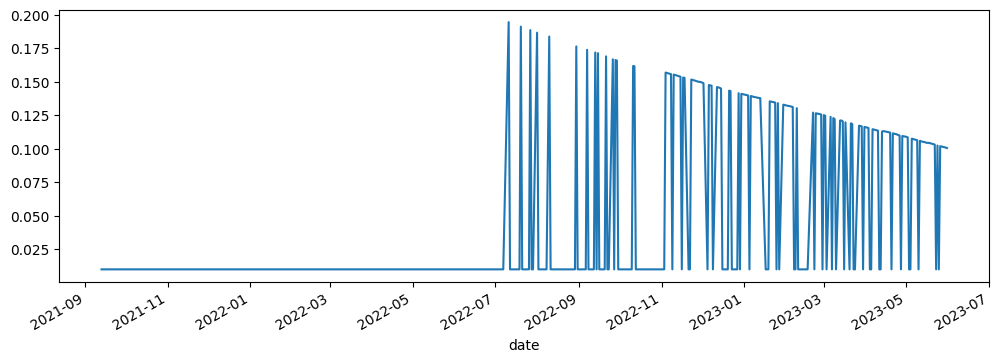

In [16]:
opt_prices_iv.bsm_iv.plot(figsize=(12, 4))

In [21]:
opt_prices_iv['l2_breaks'].sum()

41.0

In [24]:
opt_prices_iv["2022-07-01":]['l2_breaks'].sum()

18.0

In [ ]:
y_test, y_pred = lstm_experiment(opt_prices_iv["2022-07-01":])

In [26]:
# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

          Predicted 0  Predicted 1
Actual 0           31            1
Actual 1            4            0


In [27]:
# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8672839506172839


# With VOL

In [44]:
def lstm_vol_experiment(data):
  # Assuming your DataFrame is named 'data' with the 'rbf_break' and 'bsm_iv' columns, and date as the index

  # Prepare the data
  target_variable = 'l2_breaks'
  feature_variables = ['bsm_iv']

  data = data[[target_variable] + feature_variables]  # Keep target variable and selected feature variables
  data = data.astype(float)  # Convert to float if necessary

  # Split the data
  train_size = int(len(data) * 0.8)  # 80% of data for training
  train_data = data[:train_size]
  test_data = data[train_size:]

  # Prepare the data for LSTM
  window_size = 10  # Number of previous time steps to consider for prediction

  def create_dataset(X, y, window_size):
      X_data, y_data = [], []
      for i in range(len(X) - window_size):
          X_data.append(X[i:i+window_size])
          y_data.append(y[i+window_size])
      return np.array(X_data), np.array(y_data)

  X_train, y_train = create_dataset(train_data[feature_variables + [target_variable]].values, train_data[target_variable].values, window_size)
  X_test, y_test = create_dataset(test_data[feature_variables + [target_variable]].values, test_data[target_variable].values, window_size)

  # Design the LSTM model
  model = Sequential()
  model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  # Train the model
  model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

  # Make predictions on the test set
  y_pred = model.predict(X_test)
  y_pred = np.round(y_pred).flatten()

  return y_test, y_pred

In [36]:
y_test, y_pred = lstm_vol_experiment(opt_prices_iv["2022-07-01":])

Epoch 1/50
11/11 [==============================] - 2s 8ms/step - loss: 0.6497 - accuracy: 0.9006
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.5194 - accuracy: 0.9181
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.3276 - accuracy: 0.9181
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.3088 - accuracy: 0.9181
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.2933 - accuracy: 0.9181
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2933 - accuracy: 0.9181
Epoch 7/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2881 - accuracy: 0.9181
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2886 - accuracy: 0.9181
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.2860 - accuracy: 0.9181
Epoch 10/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2880 - accuracy: 0.9181
Epoch 11/50
11/11 [

In [37]:
# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

          Predicted 0  Predicted 1
Actual 0           32            0
Actual 1            4            0


In [38]:
# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8888888888888888


# Full timeseries

In [39]:
y_test, y_pred = lstm_experiment(opt_prices_iv)

# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Epoch 1/50
20/20 [==============================] - 3s 8ms/step - loss: 0.6252 - accuracy: 0.8627
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3861 - accuracy: 0.8954
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3527 - accuracy: 0.8954
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3493 - accuracy: 0.8954
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3407 - accuracy: 0.8954
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3374 - accuracy: 0.8954
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3325 - accuracy: 0.8954
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3225 - accuracy: 0.8954
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3168 - accuracy: 0.8954
Epoch 10/50
20/20 [==============================] - 0s 8ms/step - loss: 0.2952 - accuracy: 0.8954
Epoch 11/50
20/20 [

3/3 [==============================] - 0s 6ms/step
          Predicted 0  Predicted 1
Actual 0           59            4
Actual 1            5            2
Accuracy: 0.8314285714285714


In [40]:
y_test, y_pred = lstm_vol_experiment(opt_prices_iv)

# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Epoch 1/50
20/20 [==============================] - 2s 8ms/step - loss: 0.6428 - accuracy: 0.8137
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.4269 - accuracy: 0.8954
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.3472 - accuracy: 0.8954
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.3454 - accuracy: 0.8954
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3396 - accuracy: 0.8954
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3370 - accuracy: 0.8954
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3263 - accuracy: 0.8954
Epoch 8/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3190 - accuracy: 0.8954
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3019 - accuracy: 0.8954
Epoch 10/50
20/20 [==============================] - 0s 8ms/step - loss: 0.2886 - accuracy: 0.8954
Epoch 11/50
20/20 [

3/3 [==============================] - 0s 4ms/step
          Predicted 0  Predicted 1
Actual 0           60            3
Actual 1            5            2
Accuracy: 0.8857142857142857


# AAPL230616C00150000

<Axes: xlabel='date'>

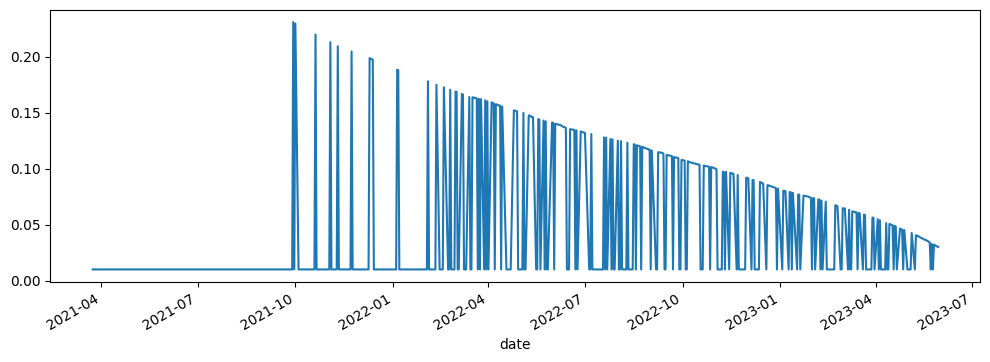

In [41]:
opt_prices_iv  = pd.read_csv('opt_prices550_iv.csv')
opt_prices_iv = opt_prices_iv.set_index('date')
opt_prices_iv.index = pd.to_datetime(opt_prices_iv.index)

get_pelt_breaks(opt_prices_iv)

opt_prices_iv.bsm_iv.plot(figsize=(12, 4))

# cut

In [42]:
y_test, y_pred = lstm_experiment(opt_prices_iv['2022-09-15':])

# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Epoch 1/50
9/9 [==============================] - 3s 10ms/step - loss: 0.6587 - accuracy: 0.8092
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 0.5862 - accuracy: 0.8321
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.5016 - accuracy: 0.8321
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4902 - accuracy: 0.8321
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4783 - accuracy: 0.8321
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4656 - accuracy: 0.8321
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 0.4682 - accuracy: 0.8321
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4652 - accuracy: 0.8321
Epoch 9/50
9/9 [==============================] - 0s 9ms/step - loss: 0.4559 - accuracy: 0.8321
Epoch 10/50
9/9 [==============================] - 0s 9ms/step - loss: 0.4523 - accuracy: 0.8321
Epoch 11/50
9/9 [=====================

In [45]:
y_test, y_pred = lstm_vol_experiment(opt_prices_iv['2022-09-15':])

# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Epoch 1/50
9/9 [==============================] - 2s 8ms/step - loss: 0.6743 - accuracy: 0.7634
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 0.6134 - accuracy: 0.8321
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.5263 - accuracy: 0.8321
Epoch 4/50
9/9 [==============================] - 0s 9ms/step - loss: 0.4844 - accuracy: 0.8321
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4833 - accuracy: 0.8321
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4677 - accuracy: 0.8321
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 0.4666 - accuracy: 0.8321
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4580 - accuracy: 0.8321
Epoch 9/50
9/9 [==============================] - 0s 10ms/step - loss: 0.4555 - accuracy: 0.8321
Epoch 10/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4614 - accuracy: 0.8321
Epoch 11/50
9/9 [=====================

# full

In [46]:
y_test, y_pred = lstm_experiment(opt_prices_iv)

# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Epoch 1/50
27/27 [==============================] - 2s 7ms/step - loss: 0.6084 - accuracy: 0.8302
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4423 - accuracy: 0.8558
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4246 - accuracy: 0.8558
Epoch 4/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4162 - accuracy: 0.8558
Epoch 5/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4054 - accuracy: 0.8558
Epoch 6/50
27/27 [==============================] - 0s 8ms/step - loss: 0.3930 - accuracy: 0.8558
Epoch 7/50
27/27 [==============================] - 0s 7ms/step - loss: 0.3726 - accuracy: 0.8558
Epoch 8/50
27/27 [==============================] - 0s 8ms/step - loss: 0.3372 - accuracy: 0.8558
Epoch 9/50
27/27 [==============================] - 0s 8ms/step - loss: 0.2736 - accuracy: 0.9047
Epoch 10/50
27/27 [==============================] - 0s 7ms/step - loss: 0.2353 - accuracy: 0.9302
Epoch 11/50
27/27 [

In [47]:
y_test, y_pred = lstm_vol_experiment(opt_prices_iv)

# Calculate the confusion matrix
confusion_matrix = calculate_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Epoch 1/50
27/27 [==============================] - 2s 7ms/step - loss: 0.5857 - accuracy: 0.8535
Epoch 2/50
27/27 [==============================] - 0s 7ms/step - loss: 0.4572 - accuracy: 0.8558
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4270 - accuracy: 0.8558
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 0.4216 - accuracy: 0.8558
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: 0.4138 - accuracy: 0.8558
Epoch 6/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4045 - accuracy: 0.8558
Epoch 7/50
27/27 [==============================] - 0s 8ms/step - loss: 0.3826 - accuracy: 0.8558
Epoch 8/50
27/27 [==============================] - 0s 8ms/step - loss: 0.3417 - accuracy: 0.8558
Epoch 9/50
27/27 [==============================] - 0s 8ms/step - loss: 0.2932 - accuracy: 0.8907
Epoch 10/50
27/27 [==============================] - 0s 8ms/step - loss: 0.2436 - accuracy: 0.9302
Epoch 11/50
27/27 [